<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/01_dnn_scratch/MLP_XOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLPによるXOR回路の作成

---

MLPでXOR出力ができるように学習してみよう！

まずはライブラリ（numpyとmatplotlib）をimportし、入力データxとその教師ラベルy_trainを設定します．

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 入力データと教師ラベル
x = np.asarray([[0,0],[1,0],[0,1],[1,1]], dtype=np.float64)
y_train = np.asarray([0, 1, 1, 0], dtype=np.float64)

## ネットワークモデルの定義
MLPを定義します．

まずはじめに，ネットワークの定義に必要なシグモイド関数を定義します．

In [3]:
# シグモイド関数の定義
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

上で定義した関数を用いてネットワークモデルを作成します．
ここでは，入力層，中間層，出力層から構成される多層パーセプトロンを定義することとし，1サンプルのデータを入力して結果を出力するようなネットワークを定義します．

入力層と中間層のユニット数は引数として与え，それぞれ`input_size`，`hidden_size`とします．
出力層サイズはユニット数は1に固定します．
そして，`__init__`関数を用いて，ネットワークのパラメータを初期化します．
`w1`および`w2`は各層の重みで，`b1`および`b2`はバイアスを表しています．
重みは`randn`関数で，標準正規分布に従った乱数で生成した値を保有する配列を生成します．
バイアスは`zeros`関数を用いて，要素が全て0の配列を生成します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．

次に，`backward`関数ではパラメータの更新量を計算します．
まず，ネットワークの出力結果と教師ラベルから，誤差`dy`を算出します．
その後，連鎖律に基づいて，出力層から順番に勾配を計算していきます．
このとき，パラメータの更新量を`self.grads`へ保存しておきます．

また，`update_parameters`関数で，更新量をもとにパラメータの更新を行う関数を定義します．ここでは，`backward`関数によって計算した勾配と更新量（`lr`）によって，現在のパラメータを更新します．

In [4]:
# MLPの定義
class MLP:

    def __init__(self, input_size, hidden_size, w_std=0.01):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, 1)
        self.b2 = np.zeros(1)
        self.grads = {}

    def forward(self, x):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = sigmoid(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.y = sigmoid(self.h3)
        return self.y

    def backward(self, x, t):
        self.grads = {}

        dy = -1 * (t - self.y)
        d_h3 = sigmoid_grad(self.h3) * dy
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)

        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = sigmoid_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)

    def update_parameters(self, lr=0.1):
        self.w1 -= lr * self.grads['w1']
        self.b1 -= lr * self.grads['b1']
        self.w2 -= lr * self.grads['w2']
        self.b2 -= lr * self.grads['b2']

入力層２（`input_size = 2`）、中間層２（`hidden_size = 2`）となるMLPのモデルを作成します。
重みとバイアスの初期値を設定する際に、標準偏差1.0（`w_std=1.0`）の乱数を設定します。
定義した`display_model_parameters`関数により初期値を表示して，重みとバイアスのそれぞれの値を確認しましょう．

In [5]:
# モデルのパラメータを表示
def display_model_parameters(model):
  print("w1:", model.w1)
  print("b1:", model.b1)
  print("w2:", model.w2)
  print("b2:", model.b2)

# モデルの作成
input_size = 2
hidden_size = 2
model = MLP(input_size=input_size, hidden_size=hidden_size, w_std=1.0)

# モデルパラメータの初期値を表示
display_model_parameters(model)

w1: [[ 0.19885797  0.03413204]
 [-1.11929012 -0.11418091]]
b1: [0. 0.]
w2: [[ 0.82162005]
 [-0.04148352]]
b2: [0.]


## MLPの学習
作成したネットワークを用いて，学習を行います．
ここでは1サンプルずつデータを入力た場合のその出力結果と教師ラベルから誤差を算出し，パラメータの更新を行います．

各更新において，学習用データと教師データをそれぞれ`input`と`label`とします．
学習モデルに`input`を与えて，分類結果である`y_pred`を取得します．
取得した`y_pred`は精度および誤差を算出するための関数へと入力され，値を保存します．
次に，誤差を`backward`関数で逆伝播し，`update_parameters`

学習終了後の重みとバイアスの値がどのように変化したかを確認しましょう．

In [6]:
# 学習パラメータの設定
num_train_data = 4
epoch_num = 1000
learning_rate = 1.0

epoch_list = []
train_loss_list = []
train_accuracy_list = []

iteration = 0
for epoch in range(1, epoch_num + 1, 1):
    sum_loss = 0.0

    for i in range(0, num_train_data, 1):
        input = x[i:i+1]
        label = y_train[i:i+1]

        y_pred = model.forward(input)

        sum_loss += np.sum(np.power(y_pred - label, 2))

        model.backward(input, label.reshape(-1, 1))
        model.update_parameters(lr=learning_rate)

    # 学習途中のlossの保存
    epoch_list.append(epoch)
    train_loss_list.append(sum_loss)
    print("epoch: {}, loss: {}".format(epoch, sum_loss))

# モデルのパラメータを表示
display_model_parameters(model)

epoch: 1, loss: 1.1117442373587332
epoch: 2, loss: 1.103935523044124
epoch: 3, loss: 1.0996216646008719
epoch: 4, loss: 1.0971834004061047
epoch: 5, loss: 1.0957444562252183
epoch: 6, loss: 1.094839953731793
epoch: 7, loss: 1.094224524590691
epoch: 8, loss: 1.0937681759202917
epoch: 9, loss: 1.0934013576969883
epoch: 10, loss: 1.0930863042448078
epoch: 11, loss: 1.092802110922806
epoch: 12, loss: 1.0925369341061852
epoch: 13, loss: 1.0922838823706449
epoch: 14, loss: 1.092038827299604
epoch: 15, loss: 1.0917992195276556
epoch: 16, loss: 1.0915634364551567
epoch: 17, loss: 1.0913304148687784
epoch: 18, loss: 1.091099438764038
epoch: 19, loss: 1.0908700134129634
epoch: 20, loss: 1.0906417884823774
epoch: 21, loss: 1.0904145097808777
epoch: 22, loss: 1.090187988182224
epoch: 23, loss: 1.0899620791454974
epoch: 24, loss: 1.0897366689503076
epoch: 25, loss: 1.0895116652926848
epoch: 26, loss: 1.089286990773954
epoch: 27, loss: 1.0890625783436654
epoch: 28, loss: 1.0888383680817864
epoch: 29

## 学習推移のグラフ化

上の学習プログラムで保存しておいた誤差をグラフ化します．


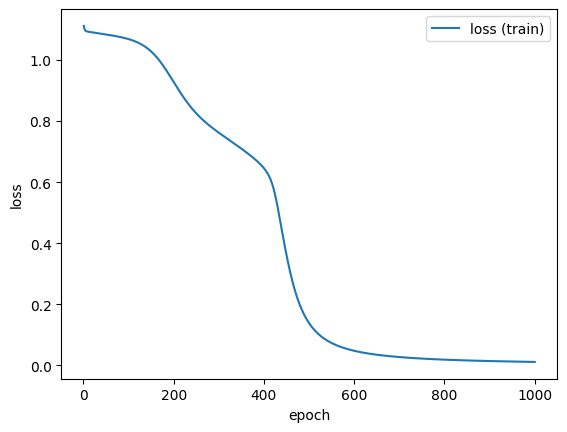

In [7]:
plt.figure()
plt.plot(epoch_list, train_loss_list, label='loss (train)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

# 出力の表示
x1とx2の値を生成し，出力結果を可視化します．

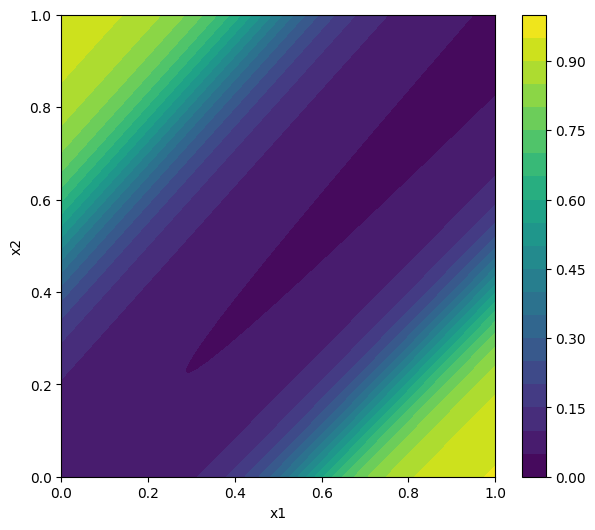

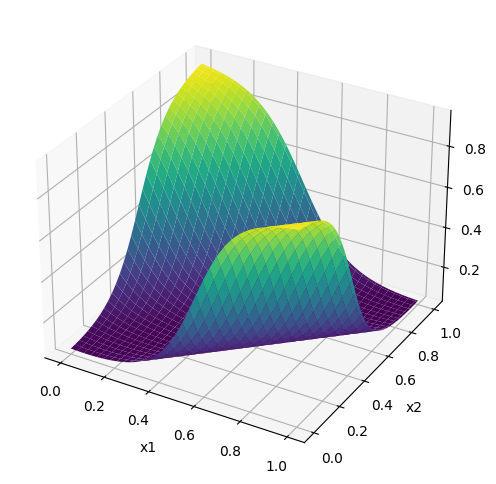

In [8]:
# x1とx2の生成
x1 = np.linspace(0, 1, 101)  # [0 0.1 ... 1.0]
x2 = np.linspace(0, 1, 101)  # [0 0.1 ... 1.0]
X1, X2 = np.meshgrid(x1, x2)

# 入力x1とx2の出力を計算しvalに代入
val = []

for v in x2:
  for u in x1:
    input = u, v
    val.append(model.forward(input))

val = np.asarray(val)
val = val.reshape(X1.shape)

# 等高線表示(PDFにセーブ)
fig, ax = plt.subplots(figsize=(7,6))
surf = ax.contourf(X1, X2, val, 20, cmap='viridis')
fig.colorbar(surf)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.savefig("MLP-2D.pdf")
plt.show()

# 3D表示 (PDFにセーブ)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1, X2, val, cmap='viridis')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.savefig("MLP-3D.pdf")
plt.show()

## 課題
1. 重みの初期値のの標準偏差を変更し学習できるか試してみよう
2. XNORの出力を学習するように変更してみよう
3. 以下の真理値表となる半加算器（X,Y：2入力、C,S：2出力）を作成してみよう

|  X  |  Y  |  C  |  S  |
| ---- | ---- | ---- | ---- |
|  0  |  0  |  0  |  0  |
|  0  |  1  |  0  |  1  |
|  1  |  0  |  0  |  1  |
|  1  |  1  |  1  |  0  |
